In [19]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.5 MB/s eta 0:00:00


In [161]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import plotly.express as px

import re
import string
from string import punctuation
import contractions

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download the Dataset

In [1]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 35.7MB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [174]:
df = pd.read_csv('spam.csv')
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


## Data Exploration

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [185]:
df['label'].value_counts()
# impalance in the dataset

,count
label,
ham,4825
spam,747


In [6]:
df.isnull().sum()

,0
text,0
label,0


In [120]:
df.duplicated().sum()

183

In [121]:
df.drop_duplicates(inplace = True)

## Data cleaning before tokinazation

In [122]:
def remove_url(list):
  cleaned = str(list).lower()
  cleaned = re.sub('https?://\S+|www\.\S+', '', cleaned)
  cleaned = contractions.fix(cleaned)
  cleaned = re.sub('\[.*?\]', '', cleaned)
  cleaned = re.sub('[%s]' % re.escape(punctuation), '', cleaned)
  cleaned = re.sub('<.*?>+', '', cleaned)
  cleaned = re.sub('\n', '', cleaned)
  cleaned = re.sub('\w*\d\w*', '', cleaned)
  return cleaned

df['text'] = df['text'].apply(lambda x: remove_url(x))

## Tokenization





In [124]:
vectorizer = CountVectorizer()
tok = vectorizer.build_tokenizer()

df['text'] = df['text'].apply(tok)

In [56]:
df['text']

,text
0,"[go, until, jurong, point, crazy, available, o..."
1,"[ok, lar, joking, wif, you, oni]"
2,"[free, entry, in, wkly, comp, to, win, fa, cup..."
3,"[you, dun, say, so, early, hor, you, already, ..."
4,"[nah, do, not, think, he, goes, to, usf, he, l..."
...,...
5567,"[this, is, the, time, we, have, tried, contact..."
5568,"[will, going, to, esplanade, fr, home]"
5569,"[pity, was, in, mood, for, that, soany, other,..."
5570,"[the, guy, did, some, bitching, but, acted, li..."


## Text Data Characteristics

In [125]:
maxLength = df['text'].apply(len).max()
maxLength

166

In [126]:
minLength = df['text'].apply(len).min()
minLength

0

### Removing rows with no text

In [127]:
row_with_no_text = df[df['text'].apply(len) == minLength]
row_with_no_text

,text,label
1611,[],ham
3092,[],ham
3374,[],ham
3740,[],spam
4822,[],ham


In [128]:
df.drop(row_with_no_text.index, inplace=True)

In [129]:
df.shape

(5384, 2)

## Most common words

In [63]:
top = Counter([word for listt in df['text'] for word in listt])
top_10 = top.most_common(20)


fig = px.bar(top_10, x=0, y=1 , labels={'0':'words', '1':'count'})
fig.show()

## Filter by text length

In [130]:
df = df[df['text'].apply(lambda x: 10 <= len(x) <= 200)]

## English stopwords

In [131]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [132]:
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

def remove_stops(list):
  return [w for w in list if w not in stops]

df['text'] = df['text'].apply(lambda x: remove_stops(x))


In [133]:
# Display most common word after removing stop words
top = Counter([word for listt in df['text'] for word in listt])
top_10 = top.most_common(20)


fig = px.bar(top_10, x=0, y=1 , labels={'0':'words', '1':'count'})
fig.show()

In [134]:
# Display most common word for 'ham' class

filtered_ham = df[df['label'] == 'ham']

top = Counter([word for listt in filtered_ham['text'] for word in listt])
top_10 = top.most_common(20)


fig = px.bar(top_10, x=0, y=1 , labels={'0':'words', '1':'count'}, title='Common words for (Ham) class')
fig.show()

In [135]:
# Display most common word for 'spam' class

filtered_spam = df[df['label'] == 'spam']

top = Counter([word for listt in filtered_spam['text'] for word in listt])
top_10 = top.most_common(20)


fig = px.bar(top_10, x=0, y=1 , labels={'0':'words', '1':'count'}, title='Common words for (Spam) class')
fig.show()

## Stemming or Lemmatization

In [106]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [136]:
from nltk.stem import WordNetLemmatizer as wnl
from nltk.stem.porter import *

stemmer = PorterStemmer()


def stemm(list):
  return [stemmer.stem(w) for w in list]


def limmatize(list):
  return [wnl().lemmatize(w) for w in list]

df['text'] = df['text'].apply(lambda x: stemm(x))
df['text'] = df['text'].apply(lambda x: limmatize(x))

In [137]:
df['text']

,text
0,"[go, jurong, point, crazi, avail, bugi, great,..."
2,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,"[dun, say, earli, hor, alreadi, say]"
4,"[nah, think, goe, usf, live, around, though]"
5,"[freemsg, hey, darl, week, word, back, would, ..."
...,...
5562,"[ok, lor, soni, ericsson, salesman, ask, shuhu..."
5564,"[wait, til, least, wednesday, see, get]"
5566,"[remind, get, pound, free, call, credit, detai..."
5567,"[time, tri, contact, pound, prize, claim, easi..."


## Joining after cleaning

In [138]:
maxLength = df['text'].apply(len).max()
maxLength

79

In [139]:
df['text'] = df['text'].apply(lambda x: ' '.join(x))

## Tokenization

In [140]:
tok = Tokenizer()
tok.fit_on_texts(df['text'])

seq = tok.texts_to_sequences(df['text'])

In [141]:
padded_seq = pad_sequences(seq, maxlen=maxLength, padding='post')

## Label encoder

In [144]:
le = LabelEncoder()
labels = le.fit_transform(df['label'])

## Train-Test split

In [146]:
X_train, X_test, y_train, y_test = train_test_split(padded_seq, labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2476, 79)
(2476,)
(620, 79)
(620,)


## Solving Impalance data using Smote

In [150]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train , y_train = sm.fit_resample(X_train, y_train)

# Building the Classifier

In [155]:
vocab_size = len(tok.word_index) + 1
embedding_size = 128
input_length = padded_seq.shape[1]


model = tf.keras.Sequential([
    # Input(shape=(input_length,)),
    tf.keras.layers.Embedding(vocab_size, 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [156]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Defining Batch Size, Creating Datasets, and Training the Model

In [157]:
batch_size = 30

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train) )
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test) )

train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)

In [158]:
history = model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 207ms/step - accuracy: 0.7183 - loss: 0.6893 - val_accuracy: 0.7952 - val_loss: 0.6836
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.7192 - loss: 0.6781 - val_accuracy: 0.8710 - val_loss: 0.7686
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.8591 - loss: 0.6590 - val_accuracy: 0.4339 - val_loss: 1.8992
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.8119 - loss: 0.7590 - val_accuracy: 0.8032 - val_loss: 0.7104
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.9136 - loss: 0.4095 - val_accuracy: 0.7984 - val_loss: 0.7111
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 201ms/step - accuracy: 0.9352 - loss: 0.3117 - val_accuracy: 0.7871 - val_loss: 0.7345
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.9513 - loss: 0.2379 - val_accuracy: 0.8000 - val_loss: 0.7013
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.9631 - loss: 0

## Model Evaluation

In [164]:
eval = model.evaluate(X_test, y_test)
print(f'Loss: {eval[0]}')
print(f'Accuracy: {eval[1]}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8552 - loss: 0.6523
Loss: 0.6608093976974487
Accuracy: 0.8451613187789917


In [173]:
eval = model.evaluate(X_train, y_train)
print(f'Loss: {eval[0]}')
print(f'Accuracy: {eval[1]}')

121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9858 - loss: 0.0791
Loss: 0.07223130017518997
Accuracy: 0.9854620695114136


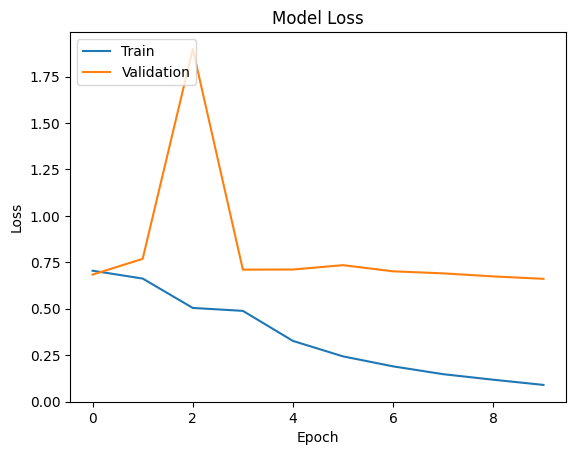

In [162]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Model Inference

In [172]:
new_text = ['Qualifications for Capture The Flag are now open!']

new_sequences = tok.texts_to_sequences(new_text)
new_padded_seq = pad_sequences(new_sequences, maxlen=input_length, padding='post')

predictions = model.predict(new_padded_seq)


# ham = 0 / spam = 1
for i, prediction in enumerate(predictions):
    predicted_label = 1 if prediction[0] > 0.5 else 0
    print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: 0


# Notebook Question:
- **How did you handle text preprocessing? Why did you choose this approach?**
- I handle it by removing punctuation, links, numbers, etc. using RE, RE



is a technique that identifies a set of strings that match, then subtract the matching string from the data for cleaning


- **Why did you choose this model design?**
- Embeddings for convert to vector space, then using Bidirectional layers to capture contextual information from both directions , then using Dense to process the output



- **Why did you pick this number of layers or units for the model?**
- We need to try

- **Why did you select these evaluation methods?**
- they are suitable with classification problems

- **Does your model show signs of overfitting or underfitting? How do you know?**
- Yes, we can know that there is an overfitting by accuracy, on training it is 98% and on testing it is 85%

- **What changes could you make to improve the model and fix overfitting or underfitting?**
- adding dropout layers , or reducing the number of layers